# Preliminary direct numerical simulation of 2D Rayleigh-Bénard convection

## Theoretical formulation
We consider the nondimensionalised equations in the Boussinesq approximation given by [Busse (1978)](https://doi.org/10.1088/0034-4885/41/12/003):
$$
\begin{align*}
    \mathrm{Pr}^{-1} \left[\partial_t \vec{u} + (\vec{u} \cdot \nabla) \vec{u}\right] &= - \nabla \pi + \nabla^2 \vec{u} + \theta \hat{z}, \\
    \partial_t \theta + (\vec{u} \cdot \nabla) \theta &= \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \nabla^2 \theta, \\
    \nabla \cdot \vec{u} &= 0
\end{align*}
$$
where:
- $\vec{u} = (u,0,w)$ is the dimensionless velocity,
- $\theta$ is the dimensionless temperature perturbation from the conductive (linear) base profile,
- $\pi$ is the dimensionless pressure perturbation from the hydrostatic base profile,
- $\mathrm{Pr}$ is the Prandtl number, the ratio of kinematic viscosity to thermal diffisivity,
- $\mathrm{Ra}$ is the Rayleigh number, the ratio of the thermal diffusion time scale to the convective time scale.

We impose no-slip, isothermal boundary conditions at the top and bottom of the domain,
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0,
\end{alignat*}
$$
and periodic lateral boundary conditions
$$
\begin{align*}
    \vec{u}(x=0) &= \vec{u}(x=L_x),\\
    \theta(x=0) &= \theta(x=L_x).
\end{align*}
$$

### Tau terms
Dedalus requires us to add *tau terms* of the form $\tau(x) P(z)$, where $\tau$ is a new degree of freedom and $P$ is a known polynomial, to the equations. This allows the non-periodic top and bottom boundary conditions to be imposed while ensuring that the system still has exact polynomial solutions (i.e., so it is solvable using spectral methods). Following [the steps in the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/tau_method.html), we introduce six new degrees of freedom
$$
    \vec{\tau}_{u1}(x) = (\tau_1(x), 0, \tau_2(x)), \quad \vec{\tau}_{u2}(x) = (\tau_3(x), 0, \tau_4(x)),
    \quad \tau_{\theta 1}(x), \quad \text{and } \tau_{\theta 2}(x).
$$
Defining the auxiliary variables
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
the equations become
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) &= 0.
\end{align*}
$$

### Pressure gauge condition
Since only the gradient of $\pi$ appears in the equations, there is a gauge freedom in the problem: the pressure is only determined up to a constant. Dedalus requires us to explicitly specify gauge conditions, so since $\pi$ is a pressure perturbation, we may as well require its mean value to be zero:
$$\int \pi ~\mathrm{d}V = 0.$$
Following [the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/gauge_conditions.html), we must also introduce a seventh spatially constant tau variable $\tau_\pi$ to the divergence equation:
$$\operatorname{Tr}(G_u) + \tau_\pi = 0.$$


### Final PDE system
The final system of equations that we will enter into Dedalus is
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) + \tau_\pi = 0,
\end{align*}
$$
with the substitutions
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
subject to the boundary conditions
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0, \\
    \int \pi ~\mathrm{d}V &= 0. && \\
\end{alignat*}
$$
(the periodic lateral boundaries are handled automatically by using a Fourier basis in the horizontal)

## Solution
This is adapted from [this example notebook](https://dedalus-project.readthedocs.io/en/latest/pages/examples/ivp_2d_rayleigh_benard.html) for 2D RBC in the Dedalus documentation.

In [29]:
import numpy as np
import dedalus.public as d3
import glob
import xarray as xr
import logging
logger = logging.getLogger(__name__)

In [137]:
# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = 2e6
Prandtl = 1
dealias = 3/2
stop_sim_time = 10
timestepper = d3.RK222
timestep = 0.1
dtype = np.float64
data_dir = '../data/prelim_dns_fine'

In [138]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
pi = dist.Field(name='pi', bases=(xbasis,zbasis))
theta = dist.Field(name='theta', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_pi = dist.Field(name='tau_pi')
tau_theta1 = dist.Field(name='tau_theta1', bases=xbasis)
tau_theta2 = dist.Field(name='tau_theta2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
x, z = dist.local_grids(xbasis, zbasis)
_, z_hat = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) - z_hat*lift(tau_u1)
grad_theta = d3.grad(theta) - z_hat*lift(tau_theta1)

# Problem
problem = d3.IVP(
    [pi, theta, u, tau_pi, tau_theta1, tau_theta2, tau_u1, tau_u2],
    namespace=locals(),
)
# Momentum equation
problem.add_equation(
    'Prandtl**(-1)*dt(u) - div(grad_u) + grad(pi) - theta*z_hat + lift(tau_u2) '
    '= - Prandtl**(-1)*u@grad_u'
)
# Energy equation
problem.add_equation(
    'dt(theta) - div(grad_theta) - Rayleigh*u@z_hat + lift(tau_theta2) '
    '= -u@grad_theta'
)
# Continuity equation
problem.add_equation('trace(grad_u) + tau_pi = 0')

# No-slip, isothermal boundary conditions
problem.add_equation('u(z=0) = 0')
problem.add_equation('u(z=Lz) = 0')
problem.add_equation('theta(z=0) = 0')
problem.add_equation('theta(z=Lz) = 0')
# Pressure gauge condition
problem.add_equation('integ(pi) = 0')

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2023-05-09 20:01:43,970 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 14s, Rate: 9.0e+00/s
2023-05-09 20:01:44,678 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 7s, Rate: 1.6e+01/s
2023-05-09 20:01:45,473 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 6s, Rate: 1.6e+01/s
2023-05-09 20:01:46,305 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 6s, Rate: 1.6e+01/s
2023-05-09 20:01:47,095 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 3s, Remaining: 5s, Rate: 1.6e+01/s
2023-05-09 20:01:47,866 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 4s, Remaining: 4s, Rate: 1.6e+01/s
2023-05-09 20:01:48,656 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 5s, Remaining: 3s, Rate: 1.6e+01/s
2023-05-09 20:01:49,485 subsystems 0/1 INFO :: Building subprob

The fluid is initially at rest, with a random normal temperature perturbation:

In [139]:
# Initial conditions
theta.fill_random('g', seed=0, distribution='normal', scale=1e-3)
theta['g'] *= 4*(z/Lz)*(1 - z/Lz) # Damp noise at walls

In [140]:
# Analysis
snapshots = solver.evaluator.add_file_handler(
    data_dir, sim_dt=0.25, max_writes=1000,
)
snapshots.add_tasks(solver.state, layout='g')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 50 == 0:
            logger.info(
                'Iteration=%i, Time=%e, dt=%e'
                % (solver.iteration, solver.sim_time, timestep)
            )
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-05-09 20:01:51,803 __main__ 0/1 INFO :: Starting main loop
2023-05-09 20:01:52,633 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-02, dt=1.000000e-02
2023-05-09 20:01:55,847 __main__ 0/1 INFO :: Iteration=51, Time=5.100000e-01, dt=1.000000e-02
2023-05-09 20:01:59,066 __main__ 0/1 INFO :: Iteration=101, Time=1.010000e+00, dt=1.000000e-02
2023-05-09 20:02:02,340 __main__ 0/1 INFO :: Iteration=151, Time=1.510000e+00, dt=1.000000e-02
2023-05-09 20:02:05,517 __main__ 0/1 INFO :: Iteration=201, Time=2.010000e+00, dt=1.000000e-02
2023-05-09 20:02:08,690 __main__ 0/1 INFO :: Iteration=251, Time=2.510000e+00, dt=1.000000e-02
2023-05-09 20:02:12,033 __main__ 0/1 INFO :: Iteration=301, Time=3.010000e+00, dt=1.000000e-02
2023-05-09 20:02:15,581 __main__ 0/1 INFO :: Iteration=351, Time=3.510000e+00, dt=1.000000e-02
2023-05-09 20:02:19,962 __main__ 0/1 INFO :: Iteration=401, Time=4.010000e+00, dt=1.000000e-02
2023-05-09 20:02:24,390 __main__ 0/1 INFO :: Iteration=451, Time=4.510000e+00, dt=1.

## Analysis

In [141]:
file = glob.glob(data_dir + '/*.h5')[0]
data = d3.load_tasks_to_xarray(file, squeeze_constant=False)
data = xr.Dataset(data)
data['ux'] = data.u.sel({'': 0})
data['uz'] = data.u.sel({'': 1})
data

<xarray.Dataset>
Dimensions:       (t: 40, x: 256, z: 64, constant: 1, : 2)
Coordinates:
    sim_time      (t) float64 0.0 0.25 0.5 0.75 1.0 ... 8.76 9.01 9.26 9.51 9.76
    world_time    (t) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wall_time     (t) float64 7.954 10.33 11.91 13.52 ... 71.82 73.41 75.04
    timestep      (t) float64 0.01 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    iteration     (t) int64 0 25 50 75 100 125 150 ... 851 876 901 926 951 976
    write_number  (t) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * x             (x) float64 0.0 0.01562 0.03125 0.04688 ... 3.953 3.969 3.984
  * z             (z) float64 0.0001506 0.001355 0.00376 ... 0.9986 0.9998
  * t             (t) float64 0.0 0.25 0.5 0.75 1.0 ... 8.76 9.01 9.26 9.51 9.76
  * constant      (constant) float64 0.0
Dimensions without coordinates: 
Data variables:
    pi            (t, x, z) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    tau_pi        (t, constant, constant) float64 0.0 nan nan ... nan nan nan
    tau_theta1    (t, x, constant) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    tau_theta2    (t, x, constant) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    tau_u1        (t, , x, constant) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    tau_u2        (t, , x, constant) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    theta         (t, x, z) float64 1.105e-07 -1.91e-07 9.175e-06 ... nan nan
    u             (t, , x, z) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ux            (t, x, z) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    uz            (t, x, z) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

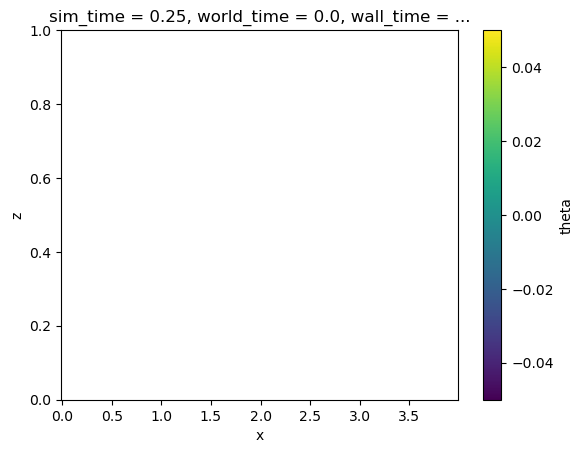

In [145]:
data.theta.isel(t=1).T.plot()